In [1]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import sys
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
import pandas as pd
import sklearn as sk
import os
import time 
from datetime import datetime
import pytz


# importing custom datasets for model 1
from customDataset_1 import Lung_Train_Dataset_1, Lung_Test_Dataset_1, Lung_Valid_Dataset_1, Lung_Train_Dataset_1_Aug
from customDataset_2 import Lung_Train_Dataset_2, Lung_Valid_Dataset_2, Lung_Test_Dataset_2, Lung_Train_Dataset_2_Aug
from customCnn_1 import NN_Classifier_1,train_model_1
from customCnn_2 import NN_Classifier_2, train_model_2
from utils import load_model, plot_curves, test_model, predict_images, validation, save_checkpoint


print(f"Pytorch Version: {torch.__version__}")
print(f"Python Version: {sys.version}")
print(f"Pandas Version: {pd.__version__}")
print(f"Sklearn Version: {sk.__version__}")
print(f"GPU is", "avaialable" if torch.cuda.is_available() else "not available")
print(torch.cuda.get_device_name(0))

Pytorch Version: 1.4.0
Python Version: 3.6.10 | packaged by conda-forge | (default, Apr 24 2020, 16:44:11) 
[GCC 7.3.0]
Pandas Version: 0.25.3
Sklearn Version: 0.23.1
GPU is avaialable
GRID V100DX-8Q


In [2]:
# image paths
train_normal_pics = 'small_proj_dataset/train/normal'
train_non_covid_pics = 'small_proj_dataset/train/infected/non-covid'
train_covid_pics = 'small_proj_dataset/train/infected/covid'
test_normal_pics = 'small_proj_dataset/test/normal'
test_non_covid_pics = 'small_proj_dataset/test/infected/non-covid'
test_covid_pics = 'small_proj_dataset/test/infected/covid'
val_normal_pics = 'small_proj_dataset/val/normal'
val_non_covid_pics = 'small_proj_dataset/val/infected/non-covid'
val_covid_pics = 'small_proj_dataset/val/infected/covid'

#### Visualising Dataset Distribution

Full dataset contains: 
1341 images for train dataset normal class
1345 images  for train dataset infected and covid class
2530 images  for train dataset infected and non-covid class
234 images  for test dataset normal class
139 images  for test dataset infected and covid class
242 images  for test dataset infected and non-covid class
8 images  for valid dataset normal class
9 images  for valid dataset infected and covid class
8 images  for valid dataset infected and non-covid class



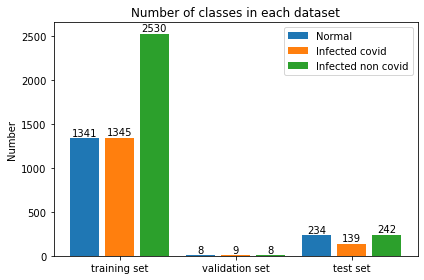

In [3]:
# checking the number of datasets present 
train_normal = len([name for name in os.listdir(train_normal_pics) if os.path.isfile(os.path.join(train_normal_pics, name))])
train_infected_non_covid = len([name for name in os.listdir(train_non_covid_pics) if os.path.isfile(os.path.join(train_non_covid_pics, name))])
train_infected_covid = len([name for name in os.listdir(train_covid_pics) if os.path.isfile(os.path.join(train_covid_pics, name))])
test_normal = len([name for name in os.listdir(test_normal_pics) if os.path.isfile(os.path.join(test_normal_pics, name))])
test_infected_non_covid = len([name for name in os.listdir(test_non_covid_pics) if os.path.isfile(os.path.join(test_non_covid_pics, name))])
test_infected_covid = len([name for name in os.listdir(test_covid_pics) if os.path.isfile(os.path.join(test_covid_pics, name))])
valid_normal = len([name for name in os.listdir(val_normal_pics) if os.path.isfile(os.path.join(val_normal_pics, name))])
valid_infected_non_covid = len([name for name in os.listdir(val_non_covid_pics) if os.path.isfile(os.path.join(val_non_covid_pics, name))])
valid_infected_covid = len([name for name in os.listdir(val_covid_pics) if os.path.isfile(os.path.join(val_covid_pics, name))])


print(f'Full dataset contains: ')
print(f'{train_normal} images for train dataset normal class')
print(f'{train_infected_covid} images  for train dataset infected and covid class')
print(f'{train_infected_non_covid} images  for train dataset infected and non-covid class')
print(f'{test_normal} images  for test dataset normal class')
print(f'{test_infected_covid} images  for test dataset infected and covid class')
print(f'{test_infected_non_covid} images  for test dataset infected and non-covid class')
print(f'{valid_normal} images  for valid dataset normal class')
print(f'{valid_infected_covid} images  for valid dataset infected and covid class')
print(f'{valid_infected_non_covid} images  for valid dataset infected and non-covid class\n')

labels = ['training set', 'validation set',  'test set']
num_normal = [train_normal, valid_normal, test_normal]
num_covid = [train_infected_covid, valid_infected_covid, test_infected_covid]
num_non_covid = [train_infected_non_covid, valid_infected_non_covid, test_infected_non_covid]
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width-.05, num_normal, width, label='Normal')
rects2 = ax.bar(x , num_covid, width, label='Infected covid')
rects3 = ax.bar(x + width+.05, num_non_covid, width, label='Infected non covid')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number')
ax.set_title('Number of classes in each dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
fig.tight_layout()

plt.show()

#### Instantiating Custom Dataset and Dataloader for model_1 (normal/infected)

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder small_proj_dataset/train/normal/: 1341 images.
 - train_infected_covid, in folder small_proj_dataset/train/infected/covid: 1345 images.
 - train_infected_non_covid, in folder small_proj_dataset/train/infected/non-covid: 2530 images.

path: small_proj_dataset/train/normal/3.jpg
class:0


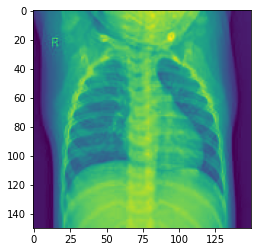

In [4]:
"""
Initialising custom train dataset for model_1
"""
ld_train = Lung_Train_Dataset_1(train_normal,train_infected_covid, train_infected_non_covid)
ld_train.describe()
# 0 - 1340 normal, 1341 - 2685 covid, 2686 - 5215 non- covid
im, class_oh, path = ld_train[3]
to_pil = torchvision.transforms.ToPILImage()
img1 = to_pil(im)
plt.imshow(img1)
# to display a single image from the custom dataset with the corresponding class label
print(f'path: {path}')
print(f'class:{class_oh}')

This is the testing dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 615 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder small_proj_dataset/test/normal/: 234 images.
 - test_infected_covid, in folder small_proj_dataset/test/infected/covid: 139 images.
 - test_infected_non_covid, in folder small_proj_dataset/test/infected/non-covid: 242 images.

path: small_proj_dataset/test/infected/non-covid/127.jpg
class:1


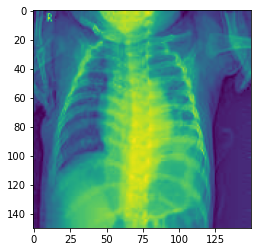

In [5]:
"""
Initialising custom test dataset for model_1
"""
ld_test = Lung_Test_Dataset_1(test_normal,test_infected_covid,test_infected_non_covid)
ld_test.describe()

# 0 - 233 normal, 234 - 372 covid, 373 - 613 non- covid
im, class_oh, path = ld_test[500]
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(im)
plt.imshow(img)
# to display a single image from the custom dataset with the corresponding class label
print(f'path: {path}')
print(f'class:{class_oh}')

This is the validation dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 25 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - valid_normal, in folder small_proj_dataset/val/normal/: 8 images.
 - valid_infected_covid, in folder small_proj_dataset/val/infected/covid: 9 images.
 - valid_infected_non_covid, in folder small_proj_dataset/val/infected/non-covid: 8 images.

path: small_proj_dataset/val/infected/non-covid/3.jpg
class:1


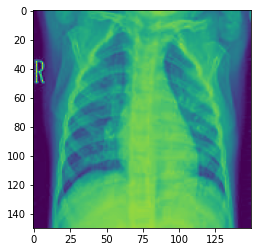

In [6]:
"""
Initialising custom val dataset for model_1
"""
ld_val = Lung_Valid_Dataset_1(valid_normal, valid_infected_covid, valid_infected_non_covid)
ld_val.describe()
# normal: 0 - 7 , infected_covid: 8-16, infected_non_covid: 17-24
im, class_oh, path = ld_val[20]
to_pil = torchvision.transforms.ToPILImage()
img3 = to_pil(im)
plt.imshow(img3)
# to display a single image from the custom dataset with the corresponding class label
print(f'path: {path}')
print(f'class:{class_oh}')

#### Optional data augmentation implementation on custom training set

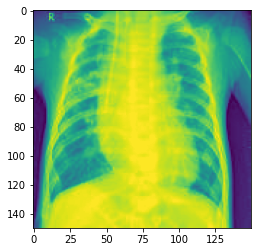

In [7]:
# set probability of transform,  p=1 here only to always display the transformed image
batch_size_value = 32

# applied brightness, contrast, saturation, hue to augment training data images
my_transforms = torchvision.transforms.RandomApply(([transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),]), p=1)

train_aug_1 = DataLoader(Lung_Train_Dataset_1_Aug(train_normal, train_infected_covid, train_infected_non_covid, transform = my_transforms), batch_size = batch_size_value, shuffle = True)
dataiter = iter(train_aug_1)
images_test, labels_test, path = dataiter.next()  # taking the first batch
to_pil = torchvision.transforms.ToPILImage()
test_img = to_pil(images_test[0])
plt.imshow(test_img)

In [8]:
"""
set batch size dependent on processing speed 
"""
batch_size_value = 32

"""
data augmentation function applied onto train dataset
"""
data_aug_transforms = torchvision.transforms.RandomApply(([transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),]), p=0.2)

"""
initialising data loader
change the train_loader object (uncomment & comment) to swap between a normal train_loader and a data augmented trainloader
"""
# train_loader = DataLoader(Lung_Train_Dataset_1_Aug(train_normal, train_infected_covid, train_infected_non_covid, transform = data_aug_transforms), batch_size = batch_size_value, shuffle = True)
train_loader = DataLoader(ld_train, batch_size = batch_size_value, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = batch_size_value, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = batch_size_value, shuffle = True)

"""
checking information on the first batch of training dataloader
"""
print(f'Number of training data: {len(ld_train)}')
print(f'Number of batches per training data: {len(train_loader)}')
dataiter = iter(train_loader)
images, labels, path = dataiter.next()  # taking the first batch
print(f'Shape of images in a single batch: {images.shape}') # output in the sequence of number of images, channels, height, width
print(f'Shape of labels in a single batch: {labels.shape}') # output is of size of number of images, each value representing label class 0,1,2

Number of training data: 5216
Number of batches per training data: 163
Shape of images in a single batch: torch.Size([32, 1, 150, 150])
Shape of labels in a single batch: torch.Size([32])


#### Training model_1 (normal/infected)

In [9]:
"""
initialising model
"""
labelsdict = {0: 'normal', 1: 'infected'}
learning_rate = 0.001
model_1 = NN_Classifier_1(output_size = len(labelsdict))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(),lr = learning_rate )
epochs = 10

"""
model and graph paths for saving
change the model_name_1 (uncomment & comment) to swap between model names for model with augmentation and no augmentation
"""
model_name_1 = 'model_1(normal_vs_infected)'
# model_name_1 = 'model_1_aug(normal_vs_infected)'
model_path_1 = f'models/model_1/checkpoint/{model_name_1}.pth'
model_path_1_best = f'models/model_1/best/{model_name_1}_best.pth'
loss_graph_1 = f'graphs/{model_name_1}_loss'
accuracy_graph_1 = f'graphs/{model_name_1}_accuracy'


Training custom CNN Model to distinguish normal and infected lungs
total epochs: 10
Epoch: 1/10 -  Time: 2021-03-21 14:39:27.847494+08:00  Training Loss: 1.227 -  Validation Loss: 0.484 -  Training Accuracy: 0.712 -  Validation Accuracy: 0.804
Validation loss decreased (1000.000000 --> 0.484205).  Saving model ...
Epoch: 2/10 -  Time: 2021-03-21 14:39:36.516966+08:00  Training Loss: 0.248 -  Validation Loss: 0.510 -  Training Accuracy: 0.908 -  Validation Accuracy: 0.785
Epoch: 3/10 -  Time: 2021-03-21 14:39:44.074946+08:00  Training Loss: 0.150 -  Validation Loss: 0.479 -  Training Accuracy: 0.946 -  Validation Accuracy: 0.833
Validation loss decreased (0.484205 --> 0.478711).  Saving model ...
Epoch: 4/10 -  Time: 2021-03-21 14:39:52.774292+08:00  Training Loss: 0.132 -  Validation Loss: 0.575 -  Training Accuracy: 0.951 -  Validation Accuracy: 0.746
Epoch: 5/10 -  Time: 2021-03-21 14:40:00.253593+08:00  Training Loss: 0.111 -  Validation Loss: 0.510 -  Training Accuracy: 0.961 -  Va

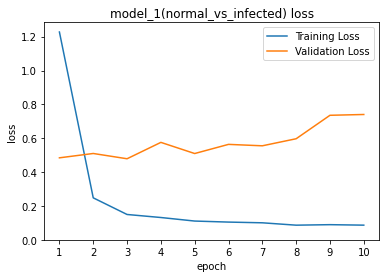

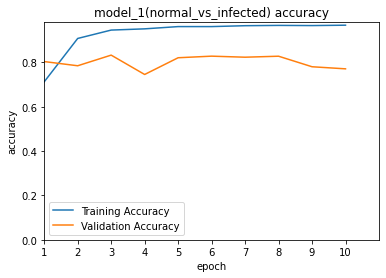

In [10]:
"""
commence training of model_1 (normal/infected) 
"""
model_one = train_model_1(model = model_1, n_epoch = epochs, labelsdict = labelsdict, criterion = criterion, optimizer = optimizer ,device = 'cuda', trainloader= train_loader, validloader= test_loader, train_data = ld_train, model_name = model_name_1, model_path = model_path_1, model_path_best = model_path_1_best, loss_graph = loss_graph_1, accuracy_graph = accuracy_graph_1) 

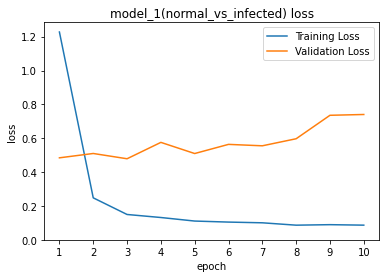

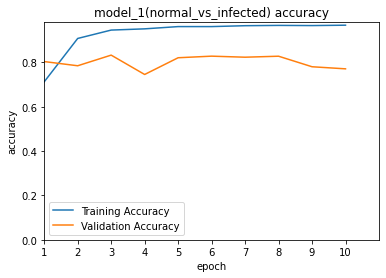

Testing Accuracy: 0.920


In [11]:
"""
loading model
"""
model_1 = load_model(NN_Classifier_1(output_size = len(labelsdict)), f'models/model_1/checkpoint/model_1(normal_vs_infected).pth')

"""
reacreating accuracy and loss graphs for model_1
"""
plot_curves(0,model_1.epoch, model_1.loss_acc, model_1.model_name, loss_graph_1, accuracy_graph_1)
"""
testing model accuracy on val_loader (25 images) 
"""
test_model(model_1, val_loader)

#### Instantiating Custom Dataset and Dataloader for model_2 (covid/non-covid)

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 3875 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_covid, in folder small_proj_dataset/train/infected/covid: 1345 images.
 - train_non_covid, in folder small_proj_dataset/train/infected/non-covid: 2530 images.

path: small_proj_dataset/train/infected/non-covid/2529.jpg
class:1


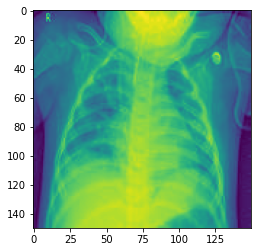

In [12]:
"""
Initialising custom train dataset for model_2 (covid/non-covid) 
"""
ld_train_2 = Lung_Train_Dataset_2(train_infected_covid, train_infected_non_covid)
ld_train_2.describe()
# covid: 0-1344, non_covid: 1345-3874
im, class_oh, path = ld_train_2[3874]
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(im)
plt.imshow(img)
# to display a single image from the custom dataset with the corresponding class label
print(f'path: {path}')
print(f'class:{class_oh}')

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 381 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_covid, in folder small_proj_dataset/test/infected/covid: 139 images.
 - train_non_covid, in folder small_proj_dataset/test/infected/non-covid: 242 images.

path: small_proj_dataset/test/infected/non-covid/0.jpg
class:1


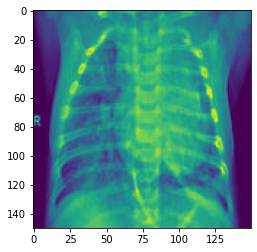

In [13]:
"""
Initialising custom test dataset for model_2 (covid/non-covid) 
"""
ld_test_2 = Lung_Test_Dataset_2(test_infected_covid, test_infected_non_covid)
ld_test_2.describe()

# covid: 0-138, non_covid: 139-380
im, class_oh, path = ld_test_2[139]
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(im)
plt.imshow(img)
# to display a single image from the custom dataset with the corresponding class label
print(f'path: {path}')
print(f'class:{class_oh}')


This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 17 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - valid_covid, in folder small_proj_dataset/val/infected/covid: 9 images.
 - valid_non_covid, in folder small_proj_dataset/val/infected/non-covid: 8 images.

path: small_proj_dataset/val/infected/covid/3.jpg
class:0


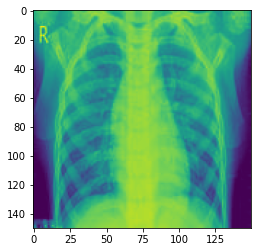

In [14]:
"""
Initialising custom val dataset for model_2 (covid/non-covid) 
"""
ld_val_2 = Lung_Valid_Dataset_2(valid_infected_covid, valid_infected_non_covid)
ld_val_2.describe()
# covid: 0-8, non_covid: 9-17
im, class_oh, path = ld_val_2[3]
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(im)
plt.imshow(img)
# to display a single image from the custom dataset with the corresponding class label
print(f'path: {path}')
print(f'class:{class_oh}')

#### Optional data augmentation implementation on custom training set

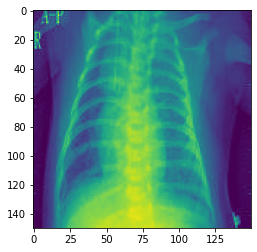

In [15]:
# set probability of transform,  p= 1 here only to always display the transformed image
batch_size_value = 32
my_transforms = torchvision.transforms.RandomApply(([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)]), p=1)
test_aug = DataLoader(Lung_Train_Dataset_2_Aug(train_infected_covid, train_infected_non_covid, transform = my_transforms), batch_size = batch_size_value, shuffle = True)
dataiter = iter(test_aug)
images_test, labels_test, path = dataiter.next()  # taking the first batch
to_pil = torchvision.transforms.ToPILImage()
test_img = to_pil(images_test[0])
plt.imshow(test_img)

#### Training model_2 (covid/non-covid)

In [32]:
data_aug_transforms = torchvision.transforms.RandomApply(([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)]), p=0.2)

"""
initialising data loader
change the train_loader object (uncomment & comment) to swap between a normal train_loader and a data augmented trainloader
"""
train_loader_2 = DataLoader(ld_train_2, batch_size = batch_size_value, shuffle = True)
# train_loader_2 = DataLoader(ld_train_2, batch_size = batch_size_value, shuffle = True)
test_loader_2 = DataLoader(ld_test_2, batch_size = batch_size_value, shuffle = True)
val_loader_2 = DataLoader(ld_val_2, batch_size = batch_size_value, shuffle = True)

"""
checking information on the first batch of training dataloader
"""
print(f'Number of training data: {len(ld_train_2)}')
print(f'Number of batches per training data: {len(train_loader_2)}')
dataiter = iter(train_loader_2)
images, labels, path = dataiter.next()  # taking the first batch
print(f'Shape of images in a single batch: {images.shape}') # output in the sequence of number of images, channels, height, width
print(f'Shape of labels in a single batch: {labels.shape}') # output is of size of number of images, each value representing label class 0,1,2

Number of training data: 3875
Number of batches per training data: 122
Shape of images in a single batch: torch.Size([32, 1, 150, 150])
Shape of labels in a single batch: torch.Size([32])


In [33]:
"""
initialising model
"""
labelsdict = {0: 'covid', 1: 'non_covid'}
learning_rate = 0.001
model_2 = NN_Classifier_2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(),lr = learning_rate )
epochs = 15

"""
model and graph paths for saving
change the model_name_2 (uncomment & comment) to swap between model names for model with augmentation and no augmentation
"""
# model_name_2 = 'model_2(covid_vs_non_covid)'
model_name_2 = 'model_2_aug(covid_vs_non_covid)'
model_path_2 = f'models/model_2/checkpoint/{model_name_2}.pth'
model_path_2_best = f'models/model_2/best/{model_name_2}_best.pth'
loss_graph_2 = f'graphs/{model_name_2}_loss'
accuracy_graph_2 = f'graphs/{model_name_2}_accuracy'

Training custom CNN Model to distinguish infected covid and infected non covid lungs
total epochs: 15
Epoch: 1/15 -  Time: 2021-03-21 14:45:11.552991+08:00  Training Loss: 0.669 -  Validation Loss: 0.656 -  Training Accuracy: 0.642 -  Validation Accuracy: 0.636
Validation loss decreased (1000.000000 --> 0.655790).  Saving model ...
Epoch: 2/15 -  Time: 2021-03-21 14:45:14.973560+08:00  Training Loss: 0.639 -  Validation Loss: 0.574 -  Training Accuracy: 0.655 -  Validation Accuracy: 0.636
Validation loss decreased (0.655790 --> 0.573574).  Saving model ...
Epoch: 3/15 -  Time: 2021-03-21 14:45:18.370698+08:00  Training Loss: 0.587 -  Validation Loss: 0.486 -  Training Accuracy: 0.687 -  Validation Accuracy: 0.806
Validation loss decreased (0.573574 --> 0.485935).  Saving model ...
Epoch: 4/15 -  Time: 2021-03-21 14:45:21.943244+08:00  Training Loss: 0.564 -  Validation Loss: 0.442 -  Training Accuracy: 0.718 -  Validation Accuracy: 0.823
Validation loss decreased (0.485935 --> 0.442049

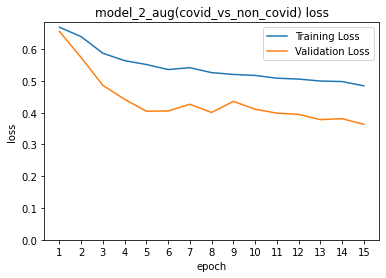

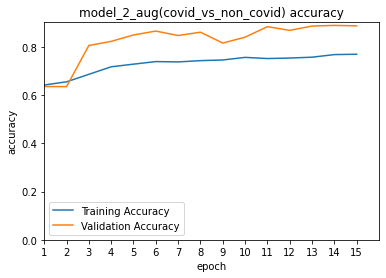

In [34]:
"""
commence training of model_2 (covid/non-covid) 
"""
model_two = train_model_2(model = model_2, n_epoch = epochs, labelsdict = labelsdict, criterion = criterion, optimizer = optimizer ,device = 'cuda', trainloader= train_loader_2, validloader= test_loader_2, train_data = ld_train_2, model_name = model_name_2, model_path = model_path_2, model_path_best = model_path_2_best, loss_graph = loss_graph_2, accuracy_graph = accuracy_graph_2) 

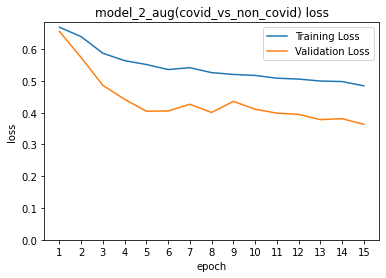

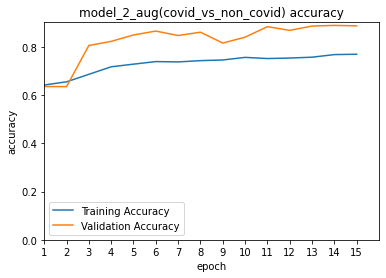

Testing Accuracy: 0.706


In [36]:
"""
loading model_2
"""
model_2 = load_model(NN_Classifier_2(), f'models/model_2/checkpoint/model_2_aug(covid_vs_non_covid).pth')

"""
reacreating accuracy and loss graphs for model_2
"""
plot_curves(0,model_2.epoch, model_2.loss_acc, model_2.model_name, loss_graph_2, accuracy_graph_2)

"""
testing model accuracy on val_loader (17 images) 
"""
test_model(model_2, val_loader_2)

#### Final Output to display Prediction on the 25 images with the two models

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from numpy import interp
from sklearn.metrics import roc_auc_score
import seaborn as sns

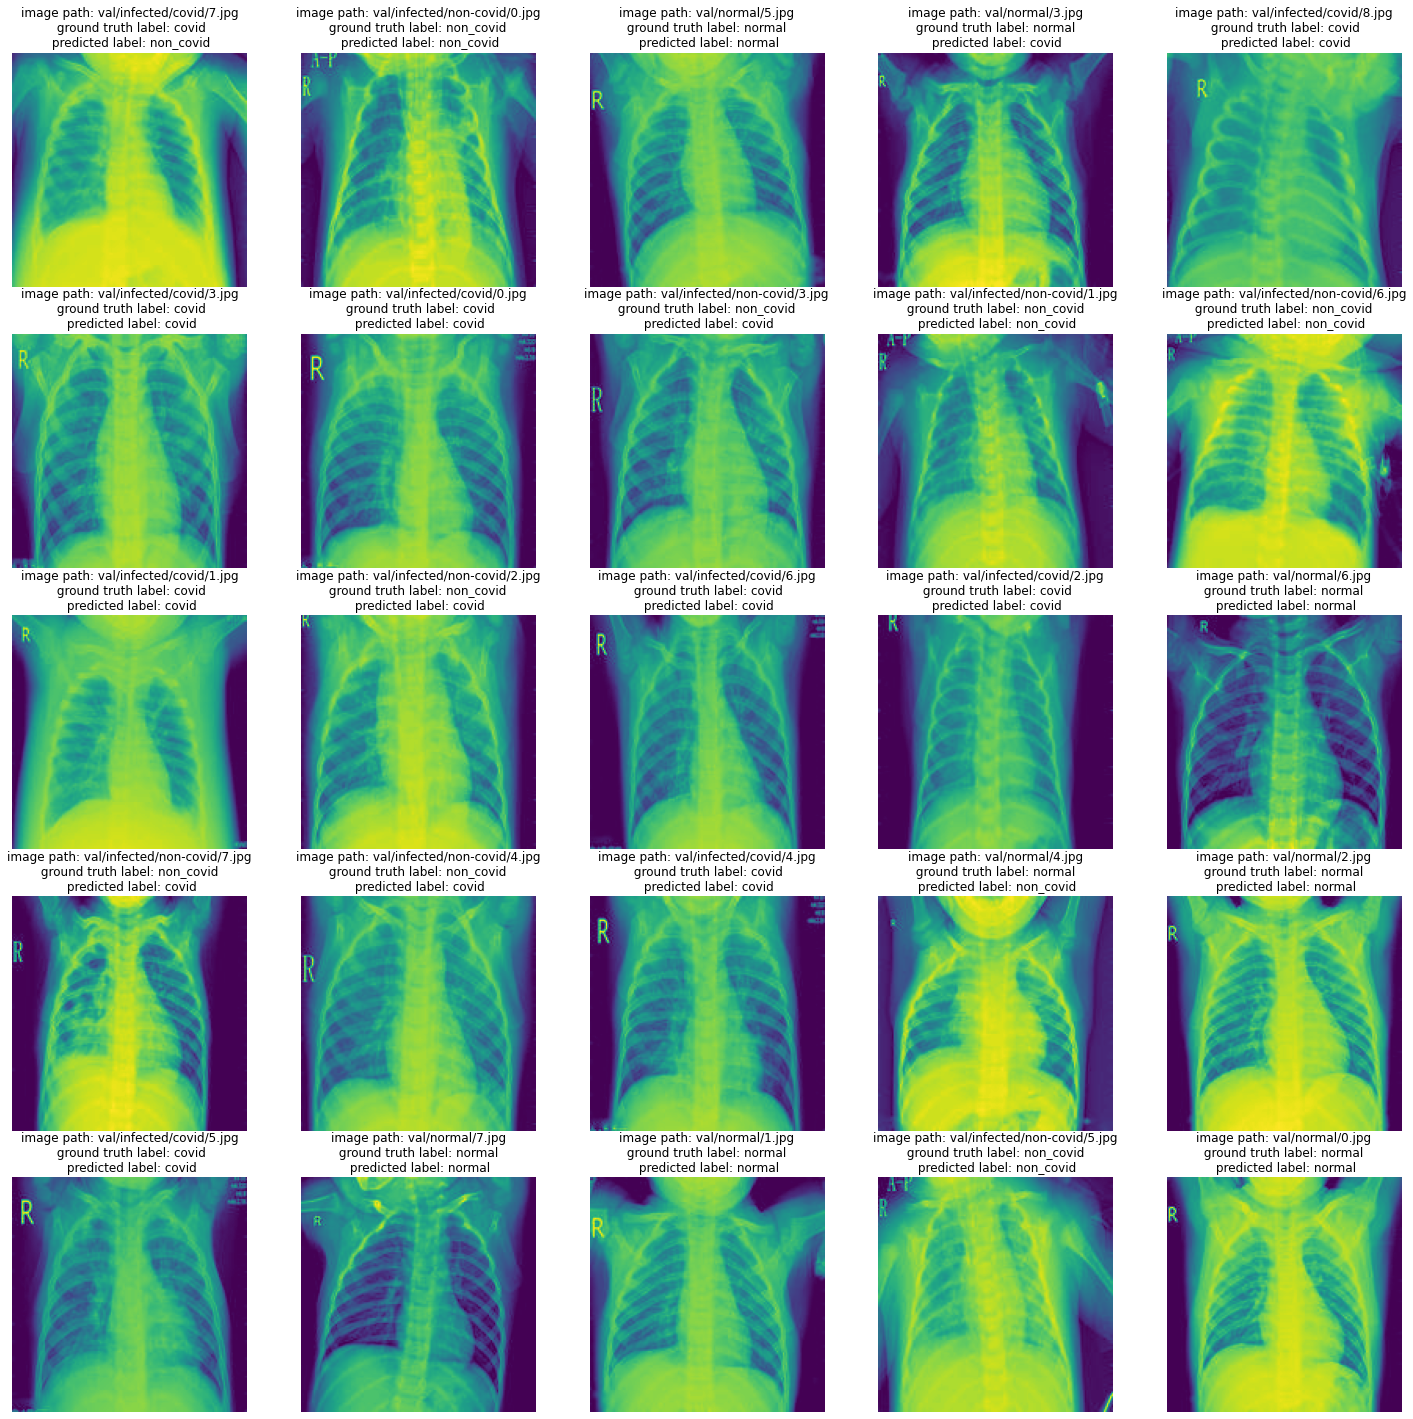

In [42]:
"""
Final Ouput to show predictions on the 25 images
"""
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

first_model = model_1
second_model = model_2

labelsdict = {0: 'normal', 1: 'infected'}
labelsdict_2 = {0:'covid', 1:'non-covid'}
width=15
height=15
rows = 5
cols = 5
axes=[]
fig=plt.figure(figsize=(25,25))

#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826


# healthy: 0 , covid:1, non-covid:2

gt_label = np.array([])
pred_label = np.array([])

for images,labels,path in val_loader:
    images, labels = images.to(device), labels.to(device)
    for i in range(images.shape[0]):
        out = predict_images(model = first_model, images = images[i:i+1], device = device)
        if torch.eq(out,torch.tensor([1]).to(device)):
            out2 = predict_images(model = second_model, images = images[i:i+1])
            predicted = second_model.labelsdict[int(out2)]
            
            # cal accuracy
            if int(out2) == 0:
                pred_label = np.append(pred_label, 1)
            elif int(out2) == 1:
                pred_label = np.append(pred_label, 2)
       
        else:
            # predicting healthy
            predicted = first_model.labelsdict[int(out)]
            pred_label = np.append(pred_label, 0)


        to_pil = torchvision.transforms.ToPILImage()
        img = to_pil(images[i].to('cpu'))
        axes.append( fig.add_subplot(rows, cols, i+1) )
        if int(labels[i]) == 0:
            axes[-1].set_title(f"image path: {path[i].strip('small_proj_dataset/')}\n ground truth label: {labelsdict[int(labels[i])]} \n predicted label: {predicted}")
            gt_label = np.append(gt_label, 0)
        elif 'non-covid' in str(path[i]):
            axes[-1].set_title(f"image path: {path[i].strip('small_proj_dataset/')}\n ground truth label: non_covid \n predicted label: {predicted}")
            gt_label = np.append(gt_label, 2)
        else:
            axes[-1].set_title(f"image path: {path[i].strip('small_proj_dataset/')}\n ground truth label: covid\n predicted label: {predicted}")
            gt_label = np.append(gt_label, 1)
                
        plt.axis('off')
        plt.imshow(img)
        
plt.show()


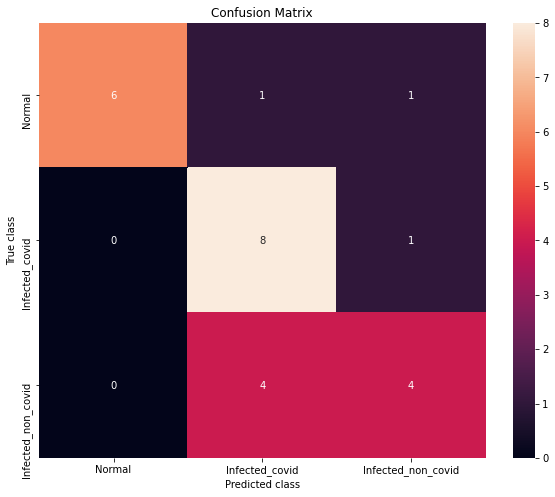

                    precision    recall  f1-score   support

            Normal       1.00      0.75      0.86         8
    Infected_covid       0.62      0.89      0.73         9
Infected_non_covid       0.67      0.50      0.57         8

          accuracy                           0.72        25
         macro avg       0.76      0.71      0.72        25
      weighted avg       0.75      0.72      0.72        25



In [44]:
"""
Ploting confusion matrix and classifiction report for better metrics on the combined performance for both models
"""

cf_matrix = confusion_matrix(gt_label, pred_label)
plt.figure(figsize=(10,8))
target_names=['Normal', 'Infected_covid', 'Infected_non_covid']
sns.heatmap(cf_matrix, xticklabels=target_names, yticklabels=target_names, annot=True, fmt = 'd')
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(f'final_confusion_matrix')
plt.show()


print(classification_report(gt_label, pred_label, target_names=['Normal', 'Infected_covid', 'Infected_non_covid']))